In [1]:
import pandas as pd
import numpy as np
import utils
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Executive Summary

### Goal
The goal of this notebook is to elucidate the components of an audio signal that cause us to perceive that audio in one way or another. To do this I attempt to predict the human construct of genre based on various audio features. The data I use were pulled from the [free music archive](https://github.com/mdeff/fma) github.

### Data
The audio columns are actually statistics of audio features extracted using the [librosa library](http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/index.html). The feature statistics which best accounted for the variability in the data were the mel frequency cepstral coefficient (mfcc) statistics. The mel frequency scale is discussed further below.

### Metrics
Predicting genre with linear regression using these statistics was 52.2% accurate which is a significant improvement over the dummy baseline of 12.5%.

### Limitations
Genre is subjective. It is an attempt to put words to a feeling. Two people can listen to a song and classify it in different genres. To get around this I used the most broad definitions of genre provided. No matter what I do the models I build will inherit the perception of genre of whoever encoded this data.

In [21]:
tracks = utils.load('../data/fma_metadata/tracks.csv')
features = utils.load('../data/fma_metadata/features.csv')

In [5]:
audio_features = set(features.columns.get_level_values(0))
audio_features

{'chroma_cens',
 'chroma_cqt',
 'chroma_stft',
 'mfcc',
 'rmse',
 'spectral_bandwidth',
 'spectral_centroid',
 'spectral_contrast',
 'spectral_rolloff',
 'tonnetz',
 'zcr'}

In [33]:
set(features['mfcc'].columns.get_level_values(0))

{'kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std'}

**Interpretation:** These are all of the audio features which this dataset has values for.

In [44]:
# https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
tracks.columns = ['_'.join(col) for col in tracks.columns.to_flat_index()]
features.columns = ['_'.join(col) for col in features.columns.to_flat_index()]

In [88]:
df.loc[df['track_genre_top'] ==  'Instrumental']

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,track_genre_top,track_title,artist_name
track_id,,,,,,,,,,,,,,,,,,,,,
10250,0.572016,4.576208,8.136117,1.212001,-0.573192,0.866814,6.298372,0.780399,-1.365938,-1.374450,...,13.467448,0.106445,0.020690,0.019531,0.000000,1.901831,0.007223,Instrumental,Tree Symphony,JayDee
11638,0.529720,0.556119,-0.510747,1.029810,0.294750,0.336503,0.635327,2.974663,0.934574,1.704977,...,3.429201,0.411621,0.085382,0.086914,0.000000,0.346689,0.030536,Instrumental,Romantic Neck Tattoo,Embarker
14568,-0.168902,-0.861651,-1.055041,-0.379003,-0.787147,-1.051911,-0.148729,-0.350007,-0.698758,1.408550,...,13.885005,0.214355,0.040505,0.035645,0.000000,3.269396,0.021600,Instrumental,Monkey Dance,Ergo Phizmiz
14569,-1.023244,-0.103863,-0.387374,0.102794,-0.827521,-1.151776,-0.522424,-0.977911,-0.252436,-0.862222,...,0.048383,0.151367,0.046528,0.047852,0.000000,0.220935,0.020395,Instrumental,Gretchen's Tango,Ergo Phizmiz
14570,-1.400652,-0.423307,-1.202632,-0.653267,-0.897179,-1.352392,-0.814049,-1.327225,-1.094677,0.307126,...,38.539307,0.151855,0.026455,0.024902,0.000000,5.578370,0.011641,Instrumental,So Wunsch Ich Dir,Ergo Phizmiz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150268,-0.838201,-0.582939,0.705787,-0.457204,-1.188803,-1.046054,-1.190121,-0.699626,-1.371778,0.174027,...,21.322025,0.247070,0.020033,0.015625,0.000000,3.391731,0.016224,Instrumental,All Who Are Weary,Hyson
152480,-0.752576,0.358721,-1.025897,-0.818031,-0.825976,-0.890393,0.228413,0.095490,-0.212854,-0.120022,...,21.329218,0.291992,0.028525,0.026367,0.000000,2.756697,0.020514,Instrumental,A Perceptible Shift,Andy G. Cohen
152568,-1.127759,-0.881541,-0.499223,0.328376,-0.119855,0.607589,1.275940,-0.593866,-0.712631,1.470136,...,53.286945,0.379395,0.028420,0.025391,0.000000,5.751756,0.020453,Instrumental,Everything Dances,Siddhartha


In [81]:
tracks.loc[tracks['set_subset'] == '']['track_genre_top'].value_counts(normalize=True)

Experimental           0.339743
Rock                   0.287788
Electronic             0.124319
Hip-Hop                0.054923
Folk                   0.052199
Pop                    0.046589
Instrumental           0.029637
Classical              0.024839
International          0.015083
Spoken                 0.012399
Jazz                   0.007602
Old-Time / Historic    0.001789
Blues                  0.001464
Soul-RnB               0.000854
Country                0.000650
Easy Listening         0.000122
Name: track_genre_top, dtype: float64

In [45]:
smol_tracks = tracks.loc[tracks['set_subset'] == 'small']

**Interpretation:** I have mp3 data for the 'small' subset only at this point.

In [46]:
smol_tracks.shape

(8000, 52)

In [47]:
smol_tracks.isna().sum().sort_values(ascending=False)[:25]

track_lyricist              7974
track_publisher             7924
track_information           7841
track_composer              7820
artist_active_year_end      7642
artist_wikipedia_page       7590
track_date_recorded         7535
artist_related_projects     7306
artist_associated_labels    7151
track_language_code         6995
album_engineer              6858
album_producer              6596
artist_active_year_begin    6458
artist_longitude            5101
artist_latitude             5101
artist_members              4475
album_date_released         2663
artist_location             2529
artist_bio                  2086
artist_website              1548
album_information           1498
album_type                   231
track_license                  5
track_interest                 0
track_genres_all               0
dtype: int64

**Interpretation:** This metadata dataset has many null values but I will be working with the audio features dataset and am only interested in the 'genre' column from this dataset.

In [48]:
features.isnull().sum().sort_values(ascending=False)[:5]

chroma_cens_kurtosis_01    0
mfcc_median_13             0
mfcc_skew_03               0
mfcc_skew_02               0
mfcc_skew_01               0
dtype: int64

**Interpretation:** No null values is music to my ears.

In [49]:
track_metadata = ['track_genre_top', 'track_title', 'artist_name']

In [50]:
df = features.merge(smol_tracks[track_metadata],
                    left_index=True, right_index=True)

In [86]:
df['track_genre_top'].value_counts(normalize=True)

Folk                   0.125094
Instrumental           0.125094
International          0.125094
Pop                    0.125094
Electronic             0.124969
Experimental           0.124969
Rock                   0.124969
Hip-Hop                0.124719
Blues                  0.000000
Classical              0.000000
Country                0.000000
Easy Listening         0.000000
Jazz                   0.000000
Old-Time / Historic    0.000000
Soul-RnB               0.000000
Spoken                 0.000000
Name: track_genre_top, dtype: float64

In [51]:
df.head()

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,track_genre_top,track_title,artist_name
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,Hip-Hop,Food,AWOL
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,Hip-Hop,This World,AWOL
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,Pop,Freeway,Kurt Vile
140,0.533579,-0.623885,-1.086205,-1.081079,-0.765151,-0.072282,-0.882913,-0.582376,-0.884749,-0.645214,...,11.052547,0.379395,0.052379,0.036621,0.001953,3.143968,0.057712,Folk,Queen Of The Wires,Alec K. Redfearn & the Eyesores
141,0.172898,-0.284804,-1.169662,-1.062855,-0.706868,-0.708281,-0.204884,0.023624,-0.642770,-0.786291,...,32.994659,0.415527,0.040267,0.034668,0.002930,4.204097,0.028665,Folk,Ohio,Alec K. Redfearn & the Eyesores


In [52]:
for dtype in df.dtypes:
    if dtype != np.number:
        print(dtype)

category
object
object


<ipython-input-52-6ed53c4ae0e6>:2: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if dtype != np.number:


**Interpretation:** The only features that are non numerical are the three metadata columns which is what I expect.

In [53]:
df.index = df.index.astype('string')

**Interpretation:** Changing the index to a string helps with indexing.

In [54]:
df.drop(['99134', '98567', '98569', '108925', '98565', '133297'], inplace=True)

**Interpretation:** These tracks have known issues and should be removed per the [github wiki.](https://github.com/mdeff/fma/wiki)

In [55]:
# df.to_csv('../data/features_with_genres.csv')

In [18]:
corr = df.corr()

In [19]:
print(df.drop(columns=track_metadata).shape[1])

print('\n', len([value for value in np.triu(corr).flatten() if value == 1]))

518

 518


**Interpretation:** The ones in the correlation matrix come from the features interacting with themselves and can be removed.

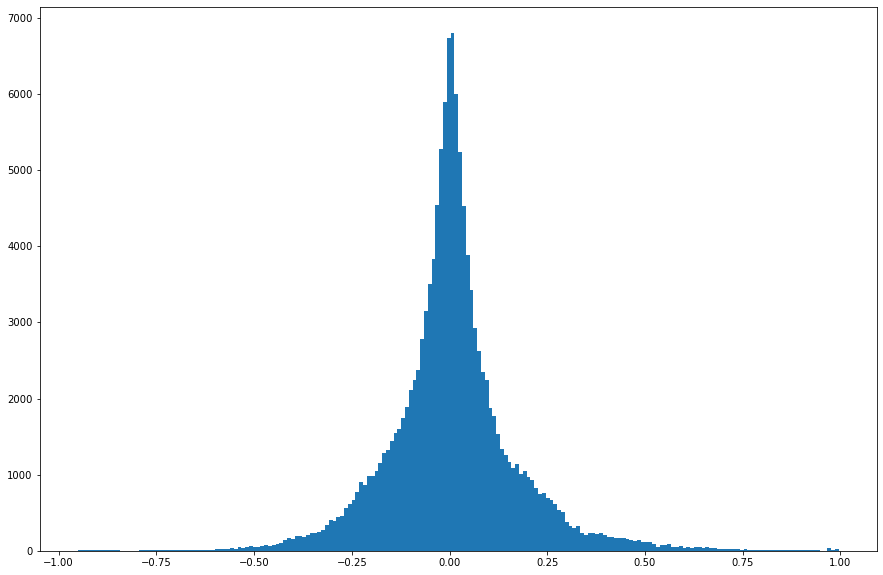

In [20]:
corr_values = [value for value in np.triu(corr).flatten()
               if (value != 0) and (value != 1)]

plt.figure(figsize = (15,10))
plt.hist(corr_values, bins=200);

**Interpretation:** There are some features that are highly correlated with others but the majority of the features are not very correlated with each other.

# Free Lunch Analysis

I start by doing some modeling on the entire dataset.

In [45]:
df['track_genre_top'].value_counts(normalize=True)

Folk                   0.125094
Instrumental           0.125094
International          0.125094
Pop                    0.125094
Electronic             0.124969
Experimental           0.124969
Rock                   0.124969
Hip-Hop                0.124719
Blues                  0.000000
Classical              0.000000
Country                0.000000
Easy Listening         0.000000
Jazz                   0.000000
Old-Time / Historic    0.000000
Soul-RnB               0.000000
Spoken                 0.000000
Name: track_genre_top, dtype: float64

**Interpretation:** The baseline accuracy is 12.5%

In [35]:
X = df.drop(columns=track_metadata)
y = df['track_genre_top']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                   random_state=42)

In [36]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

### Random Forest Classifier

In [62]:
forest = RandomForestClassifier(max_depth = 3, n_estimators = 750,
                                random_state=42)
cross_val_score(forest, X_train, y_train, n_jobs=5)

array([0.42535446, 0.43703086, 0.4295246 , 0.41534612, 0.43786489])

In [63]:
forest.fit(X_train, y_train)
forest.score(X_test, y_test), forest.score(X_train, y_train)

(0.4242121060530265, 0.4482068390325271)

**Interpretation:** This model is overfit but not too badly.

### Gradient Boosting Classifier

In [53]:
gbm = GradientBoostingClassifier(min_samples_split = 10, subsample = .7,
                                 max_features = 'sqrt', n_iter_no_change = 5,
                                 n_estimators = 500, learning_rate = .0001,
                                 tol = .0001, verbose=0)
cross_val_score(gbm, X_test, y_test)

array([0.49      , 0.485     , 0.4675    , 0.4525    , 0.45614035])

In [54]:
gbm.fit(X_train, y_train)
gbm.score(X_test, y_test), gbm.score(X_train, y_train)

(0.4822411205602801, 0.5451209341117598)

In [126]:
pd.DataFrame(gbm.feature_importances_,
             index=X_train.columns).sort_values(by=0, ascending=False)[:10]

,0
mfcc_mean_03,0.018655
spectral_bandwidth_median_01,0.018544
spectral_rolloff_median_01,0.018296
mfcc_median_03,0.018201
spectral_rolloff_mean_01,0.017159
spectral_centroid_median_01,0.017146
mfcc_median_01,0.016058
spectral_bandwidth_mean_01,0.015332
mfcc_max_04,0.014835
spectral_centroid_mean_01,0.014701


**Interpretation:** The gradient boosting improved the score however it also resulted in a more overfit model. I would like to do a gridsearch on this one to see if I can reduce the overfitting.

### Logistic Regression

In [81]:
lrcv = LogisticRegressionCV(max_iter = 1000)
lrcv.fit(X_train_sc, y_train)

/home/icculus/anaconda3/envs/audio_processing/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/icculus/anaconda3/envs/audio_processing/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

LogisticRegressionCV(max_iter=1000)

In [68]:
lrcv.score(X_test_sc, y_test), lrcv.score(X_train_sc, y_train)

(0.5767883941970986, 0.6662218515429524)

In [74]:
lrcv.C_

array([0.00599484, 0.00599484, 0.00599484, 0.00599484, 0.00599484,
       0.00599484, 0.00599484, 0.00599484])

**Interpretation:** I will use 0.00599484 as my regularization strength. The logistic regression did not converge and I believe this is because there are too many columns for the number of rows used in each cross validation fold.

In [40]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
cross_val_score(lr, X_train_sc, y_train)

array([0.57130942, 0.58381985, 0.57714762, 0.57964971, 0.57214345])

In [41]:
lr.fit(X_train_sc, y_train)
lr.score(X_test_sc, y_test), lr.score(X_train_sc, y_train)

(0.5767883941970986, 0.6662218515429524)

**Interpretation:** This model is overfit but it did a lot better than my tree based models. This suggests a linear relationship between frequency features and genre.

In [42]:
pd.DataFrame(lr.coef_, columns=X_train.columns)

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,-0.025476,-0.040860,0.046156,-0.020667,0.013745,-0.042973,-0.029480,0.006136,-0.043726,-0.012364,...,0.001908,0.060594,0.026367,0.035498,-0.018625,-0.096307,-0.106073,-0.046290,-0.038620,-0.049738
1,-0.028519,0.025212,-0.014948,0.033314,0.029537,0.010640,0.011014,0.048996,-0.003017,-0.049361,...,-0.018302,0.080415,0.059661,0.021753,0.014725,0.110615,0.106609,0.004292,0.061645,0.105421
2,-0.000515,0.002466,0.009605,0.029150,0.016663,-0.028863,0.020518,0.007512,-0.017631,-0.015496,...,0.056307,-0.015243,0.025717,-0.033696,-0.032843,-0.029041,-0.052745,-0.002298,-0.031203,0.046943
3,-0.039642,-0.001999,0.001909,0.017456,-0.012945,-0.051661,0.024997,-0.014093,0.057557,0.042876,...,-0.037456,0.009253,0.040067,-0.087244,0.041155,-0.004572,-0.047306,-0.066815,-0.073214,0.062228
4,0.051651,0.022450,-0.009980,0.014735,0.004337,0.051394,-0.011206,-0.000238,0.023194,0.027762,...,0.034720,0.053814,0.046613,-0.010851,-0.099041,0.024798,0.031751,0.043926,0.003313,0.020369
5,-0.023276,-0.007128,-0.027687,0.019164,-0.010902,-0.020055,-0.008239,-0.038517,-0.078769,-0.032976,...,-0.131480,-0.139608,-0.177339,-0.013824,0.025777,-0.041964,-0.042816,0.148997,-0.058526,-0.099874
6,0.005609,-0.006871,-0.008739,-0.001487,-0.022034,0.051091,-0.027552,0.017025,0.034494,0.050623,...,0.071284,-0.007914,0.001182,0.010550,0.062617,-0.016564,-0.007123,-0.111132,0.112005,-0.023881
7,0.060169,0.006729,0.003683,-0.091664,-0.018399,0.030427,0.019948,-0.026821,0.027897,-0.011065,...,0.023019,-0.041311,-0.022269,0.077812,0.006237,0.053033,0.117703,0.029320,0.024600,-0.061468


# Principal Component Analysis

In [83]:
pca = PCA()
pca.fit(X_train_sc)

PCA()

In [85]:
len(X_train)**.5

77.42738533619743

In [116]:
sum([round(val, 5) for val in pca.explained_variance_ratio_][:77])

0.7921899999999997

**Interpretation:** As a rule of thumb I like to try reducing features down to square root of the length of my data which in this case is 77. ~80% of the variability is explained by the first 77 principal components.

In [111]:
pca = PCA(77)
pca.fit(X_train_sc)

X_train_pca = pd.DataFrame(pca.transform(X_train_sc))
X_test_pca = pd.DataFrame(pca.transform(X_test_sc))

In [112]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
cross_val_score(lr, X_train_pca, y_train)

array([0.52543786, 0.55629691, 0.5471226 , 0.54295246, 0.53127606])

In [113]:
lr.fit(X_train_pca, y_train)
lr.score(X_test_pca, y_test), lr.score(X_train_pca, y_train)

(0.5387693846923461, 0.5694745621351126)

**Interpretation:** This logistic regression has an increase in bias but a greater reduction in overfitting. It is ~5% less accurate on the test set and 10% less accurate on the training set.

## Chroma Cens Analysis
Instead of putting all of the features into my models I investigate specific ones to judge which are most important.

**Audio Features**
- 'chroma_cens
- 'chroma_cqt'
- 'chroma_stft'
- 'mfcc'
- 'rmse'
- 'spectral_bandwidth'
- 'spectral_centroid'
- 'spectral_contrast'
- 'spectral_rolloff'
- 'tonnetz'
- 'zcr'

In [57]:
chroma_cens_cols = [col for col in df.columns if 'chroma_cens' in col]
tonnetz_cols = [col for col in df.columns if 'tonnetz' in col]
spectral_bdwth_cols = [col for col in df.columns if 'spectral_bandwidth' in col]
mfcc_cols = [col for col in df.columns if 'mfcc' in col]

In [135]:
X = df[chroma_cens_cols]
y = df['track_genre_top']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                   random_state=42)

In [136]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [148]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_sc, y_train)
lr.score(X_test_sc, y_test), lr.score(X_train_sc, y_train)

(0.27963981990995496, 0.30825688073394497)

**Interpretation:** While this model is better than the baseline it does not do nearly as well as the logistic regression on the full dataset. These summary statistics on the chroma energy normalized chromagram probably aren't the best features.

In [150]:
pca = PCA()
pca.fit(X_train_sc)

PCA()

In [139]:
len(X_train.columns)

84

In [144]:
sum([round(val, 5) for val in pca.explained_variance_ratio_][:42])

0.9510099999999997

**Interpretation:** 95% of the variability of the data is captured in the first 42 principal components.

In [153]:
pca = PCA(42)
pca.fit(X_train_sc)

PCA(n_components=42)

In [154]:
X_train_pca = pd.DataFrame(pca.transform(X_train_sc))
X_test_pca = pd.DataFrame(pca.transform(X_test_sc))

In [155]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_pca, y_train)
lr.score(X_test_pca, y_test), lr.score(X_train_pca, y_train)

(0.2726363181590795, 0.28990825688073396)

**Interpretation:** Principal component analysis helped to reduce overfitting in this model but not by much.

## Tonnetz Analysis

In [56]:
X = df[tonnetz_cols]
y = df['track_genre_top']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                   random_state=42)

NameError: name 'tonnetz_cols' is not defined

In [159]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [164]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_sc, y_train)
lr.score(X_test_sc, y_test), lr.score(X_train_sc, y_train)

(0.27913956978489246, 0.31075896580483736)

**Interpretation:** While this model is better than the baseline it does not do nearly as well as the logistic regression on the full dataset. These summary statistics on the tonnetz probably aren't the best features.

In [165]:
pca = PCA()
pca.fit(X_train_sc)

PCA()

In [166]:
len(X_train.columns)

42

In [168]:
sum([round(val, 5) for val in pca.explained_variance_ratio_][:21])

0.9288200000000001

**Interpretation:** 93% of the variability of the data is captured in the first 21 principal components.

In [170]:
pca = PCA(21)
pca.fit(X_train_sc)

PCA(n_components=21)

In [171]:
X_train_pca = pd.DataFrame(pca.transform(X_train_sc))
X_test_pca = pd.DataFrame(pca.transform(X_test_sc))

In [173]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_pca, y_train)
lr.score(X_test_pca, y_test), lr.score(X_train_pca, y_train)

(0.26263131565782893, 0.28607172643869894)

**Interpretation:** Principal component analysis helped to reduce overfitting in this model but not by much.

## MFCC Analysis

In [58]:
X = df[mfcc_cols]
y = df['track_genre_top']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                   random_state=42)

In [69]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [70]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_sc, y_train)
lr.score(X_test_sc, y_test), lr.score(X_train_sc, y_train)

(0.5222611305652827, 0.538115095913261)

**Interpretation:** The accuracy here is pretty close to the accuracy on the entire dataset! The accuracy of the logistic regression with all of the features was 57.7 on the test set and 66.6 on the training set. Not only is the accuracy close but overfitting has been reduced by a lot.

In [176]:
pca = PCA()
pca.fit(X_train_sc)

PCA()

In [177]:
len(X_train.columns)

140

In [179]:
sum([round(val, 5) for val in pca.explained_variance_ratio_][:77])

0.97095

In [180]:
pca = PCA(77)
pca.fit(X_train_sc)

PCA(n_components=77)

In [181]:
X_train_pca = pd.DataFrame(pca.transform(X_train_sc))
X_test_pca = pd.DataFrame(pca.transform(X_test_sc))

In [185]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
cross_val_score(lr, X_train_sc, y_train)

array([0.50708924, 0.52126772, 0.49958299, 0.49791493, 0.49958299])

In [183]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_pca, y_train)
lr.score(X_test_pca, y_test), lr.score(X_train_pca, y_train)

(0.5102551275637819, 0.5287739783152627)

In [188]:
gbm = GradientBoostingClassifier(min_samples_split = 10, subsample = 1,
                                 max_features = 'sqrt', n_iter_no_change = 5,
                                 n_estimators = 500, learning_rate = .0001,
                                 tol = .0001, verbose=1)
gbm.fit(X_train, y_train)
gbm.score(X_test, y_test), gbm.score(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           2.0794            1.12m
         2           2.0793            1.11m
         3           2.0792            1.09m
         4           2.0791            1.09m
         5           2.0790            1.08m
         6           2.0789            1.08m
         7           2.0788            1.09m
         8           2.0787            1.09m
         9           2.0786            1.10m
        10           2.0785            1.09m
        20           2.0777            1.06m
        30           2.0768            1.03m
        40           2.0759            1.01m
        50           2.0750           58.87s
        60           2.0742           57.45s
        70           2.0733           56.31s
        80           2.0724           55.04s
        90           2.0715           53.74s
       100           2.0707           52.43s
       200           2.0621           39.09s
       300           2.0536           26.02s
       40

(0.455, 0.5151666666666667)

In [189]:
gbm = GradientBoostingClassifier(min_samples_split = 10, subsample = 1,
                                 max_features = 'sqrt', n_iter_no_change = 5,
                                 n_estimators = 500, learning_rate = .0001,
                                 tol = .0001, verbose=1)
gbm.fit(X_train_pca, y_train)
gbm.score(X_test_pca, y_test), gbm.score(X_train_pca, y_train)

      Iter       Train Loss   Remaining Time 
         1           2.0794           45.01s
         2           2.0793           44.64s
         3           2.0793           45.51s
         4           2.0793           45.18s
         5           2.0792           44.79s
         6           2.0792           44.74s
         7           2.0791           44.63s
         8           2.0791           44.38s
         9           2.0790           44.31s
        10           2.0790           44.11s
        20           2.0785           42.81s
        30           2.0780           41.73s
        40           2.0775           40.83s
        50           2.0770           39.80s
        60           2.0764           38.78s
        70           2.0760           37.80s
        80           2.0755           36.87s
        90           2.0750           35.96s
       100           2.0745           35.03s
       200           2.0698           26.13s
       300           2.0650           17.43s
       40

(0.4445, 0.5128333333333334)

In [95]:
y, sr = librosa.load('../data/fma_small/065/065488.mp3')

/home/icculus/anaconda3/envs/audio_processing/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [96]:
len(y), 48000 * 30

(661257, 1440000)

Librosa has a default sampling rate of 22,050 hertz. Audio track is ~30s long.

In [97]:
y[50000:50020]

array([-0.13071546, -0.14464088, -0.1533173 , -0.15577039, -0.16569342,
       -0.16450326, -0.1675261 , -0.16692555, -0.15473306, -0.1462071 ,
       -0.13893834, -0.12778008, -0.12455088, -0.12911698, -0.13149291,
       -0.13620712, -0.13178138, -0.1211876 , -0.11091308, -0.09449333],
      dtype=float32)

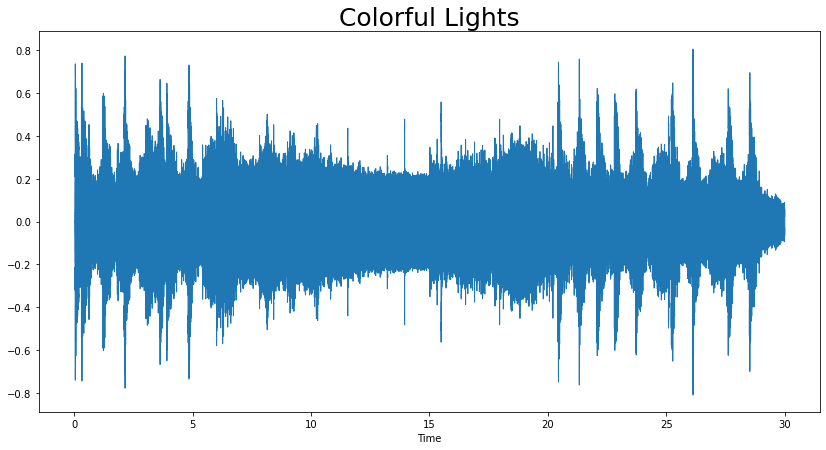

In [114]:
fig = plt.figure(figsize = (14, 7))
librosa.display.waveshow(y)
plt.title('Colorful Lights', size=25)
plt.savefig('../images/waveform.png');

In [115]:
stft = librosa.stft(y, sr)

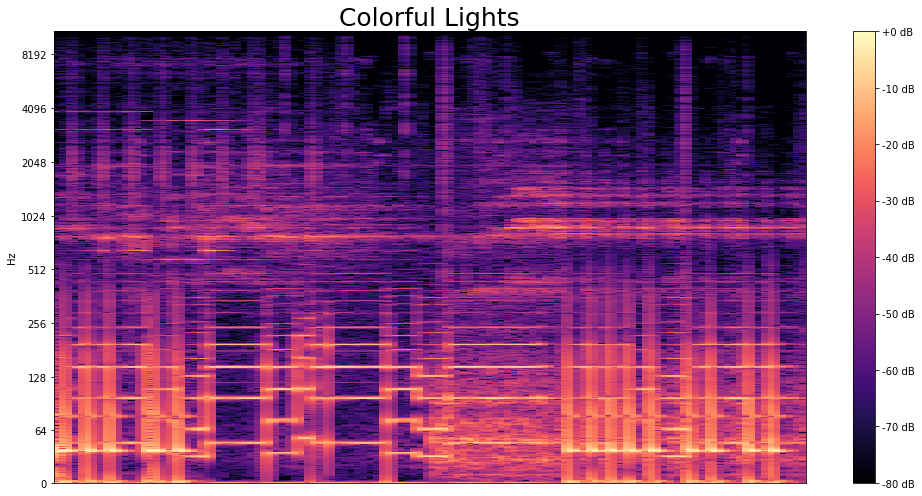

In [144]:
# http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.core.stft.html#librosa.core.stft

fig = plt.figure(figsize = (14, 7))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft),
                                                 ref=np.max),
                        y_axis='log')
plt.title('Colorful Lights', size=25)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.savefig('../images/stft.png');

In [145]:
mel_filters = librosa.filters.mel(sr, 2048)

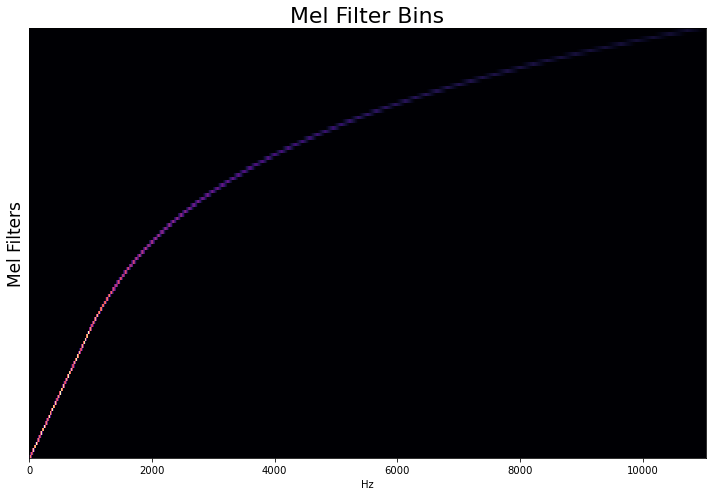

In [160]:
# http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.filters.mel.html#librosa.filters.mel

plt.figure(figsize=(10,7))
librosa.display.specshow(mel_filters, x_axis='linear')
plt.title('Mel Filter Bins', size = 22)
plt.ylabel('Mel Filters', size = 17)
plt.tight_layout()
plt.savefig('../images/mel_filter_bins.png');

In [161]:
mel_spec = librosa.feature.melspectrogram(y, sr)

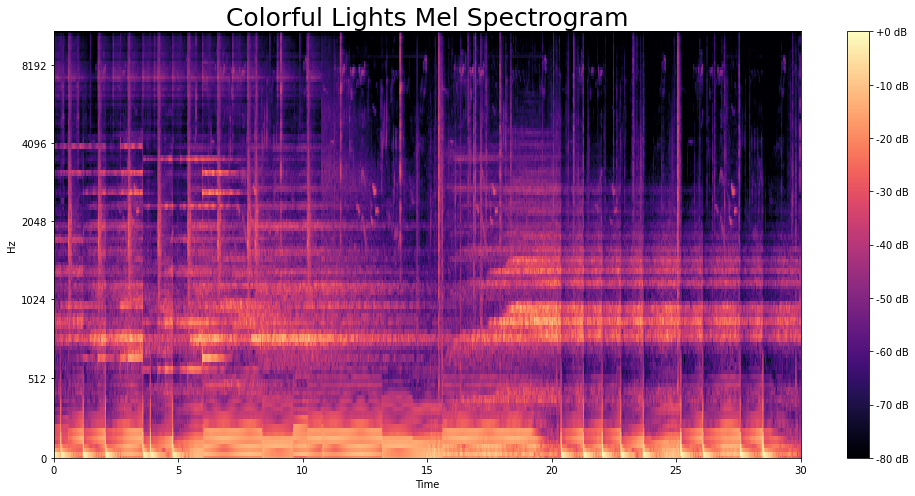

In [169]:
# http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram

fig = plt.figure(figsize = (14, 7))

librosa.display.specshow(librosa.power_to_db(mel_spec,
                                             ref=np.max),
                        y_axis='mel', x_axis='time')
plt.title('Colorful Lights Mel Spectrogram', size=25)
plt.tight_layout()
plt.colorbar(format='%+2.0f dB')
plt.savefig('../images/mel_spec.png');

In [171]:
mfcc = librosa.feature.mfcc(y, hop_length=512)

In [172]:
mfcc[0]

array([-270.3988 , -245.5079 , -248.37785, ..., -272.64008, -278.76825,
       -215.09084], dtype=float32)

In [173]:
mfcc.shape

(20, 1292)

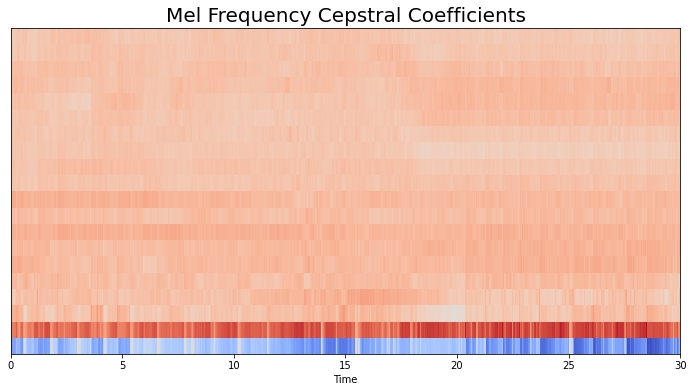

In [178]:
# http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.feature.mfcc.html#librosa.feature.mfcc

fig = plt.figure(figsize = (12, 6))
librosa.display.specshow(mfcc, x_axis='time')
plt.title('Mel Frequency Cepstral Coefficients', size=20)
plt.savefig('../images/mffcs.png')

In [53]:
mfcc_delta = librosa.feature.delta(mfcc)

In [54]:
# look more into this
mfcc_delta.shape

(20, 2812)

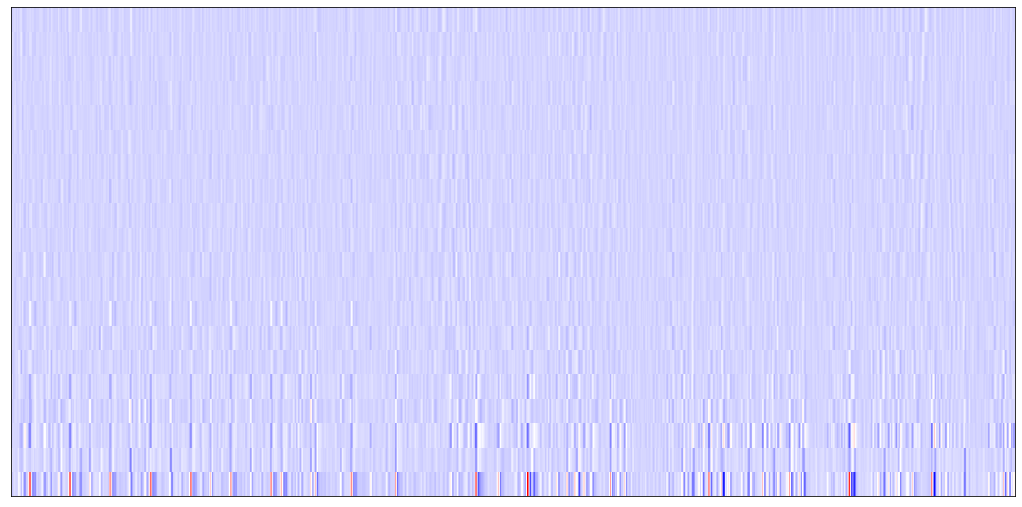

In [98]:
fig = plt.figure(figsize = (18, 9))
librosa.display.specshow(mfcc_delta, cmap='bwr')

In [56]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

In [57]:
y_harmonic.shape, y_percussive.shape

((1439471,), (1439471,))

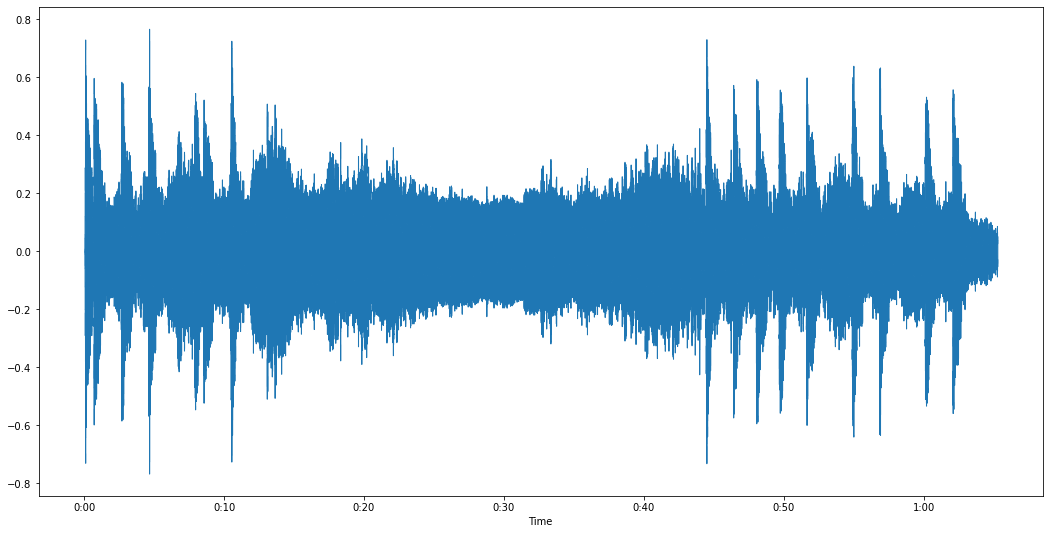

In [99]:
fig = plt.figure(figsize = (18, 9))
librosa.display.waveshow(y_harmonic)

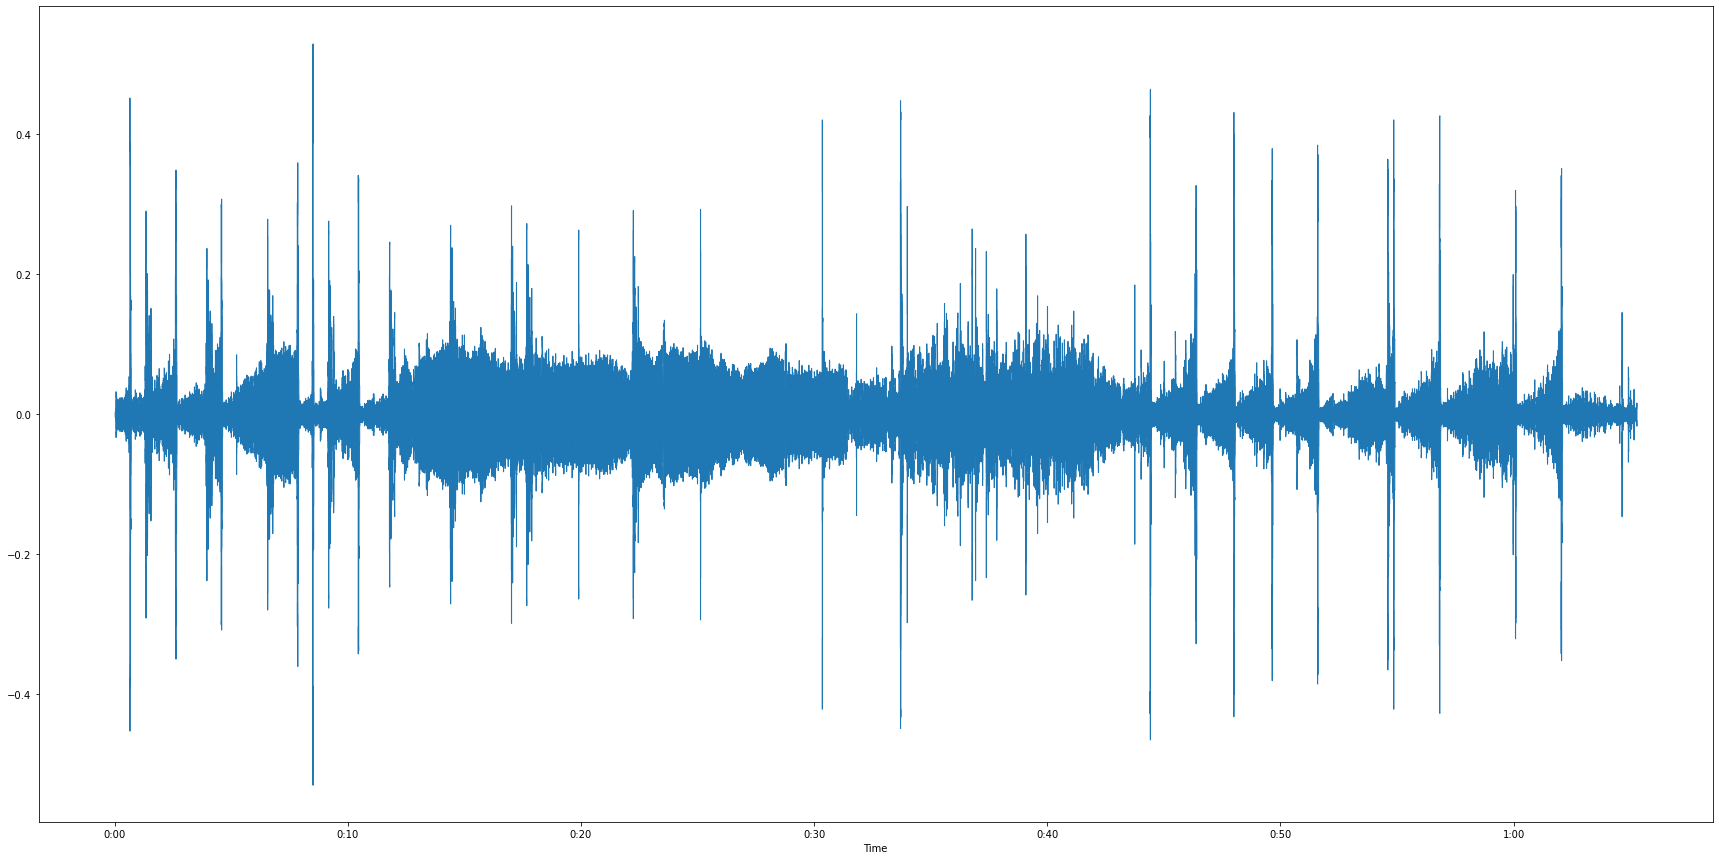

In [59]:
fig = plt.figure(figsize = (18, 9))
librosa.display.waveshow(y_percussive)

In [60]:
sf.write('percussive_test_file_48000.wav', y_percussive, 48000)

In [61]:
sf.write('harmonic_test_file_48000.wav', y_harmonic, 48000)

In [62]:
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr = 48000)

In [63]:
tempo

100.44642857142857

In [64]:
print(beat_frames.shape)
beat_frames

(50,)


array([   3,   57,  113,  170,  226,  282,  337,  395,  450,  507,  563,
        619,  676,  733,  795,  857,  909,  958, 1012, 1082, 1139, 1196,
       1254, 1307, 1370, 1421, 1476, 1533, 1584, 1630, 1683, 1733, 1784,
       1843, 1897, 1959, 2014, 2075, 2124, 2184, 2238, 2292, 2352, 2407,
       2463, 2529, 2583, 2635, 2689, 2743])

In [65]:
beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]), beat_frames)

In [66]:
beat_mfcc_delta.shape

(40, 51)

more filters later

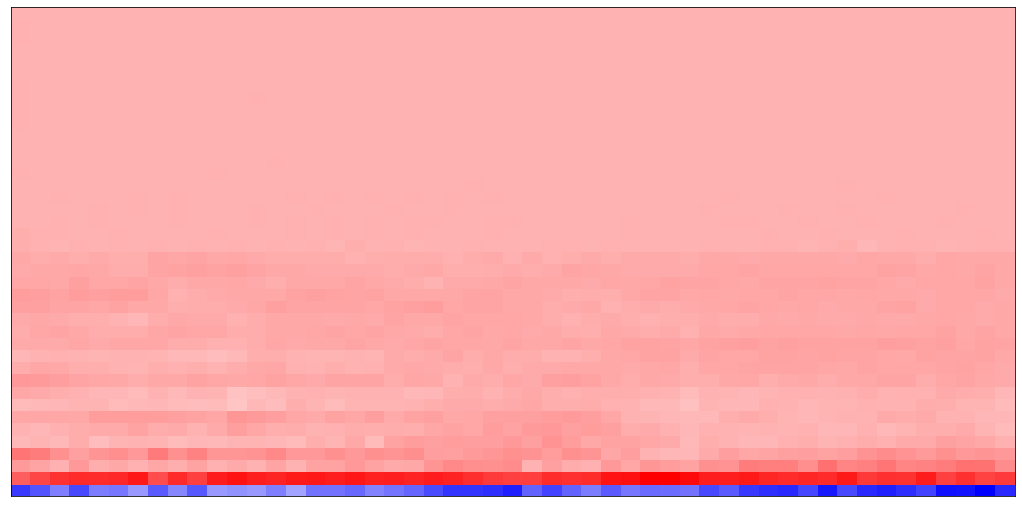

In [100]:
fig = plt.figure(figsize = (18, 9))
librosa.display.specshow(beat_mfcc_delta, cmap='bwr')

In [61]:
len(y_harmonic)

1439471

In [62]:
1439471 / 512

2811.466796875

In [57]:
chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr= 48000)

In [58]:
chromagram.shape

(12, 2812)

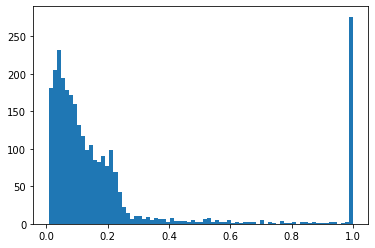

In [68]:
plt.hist(chromagram[0], bins = 75);

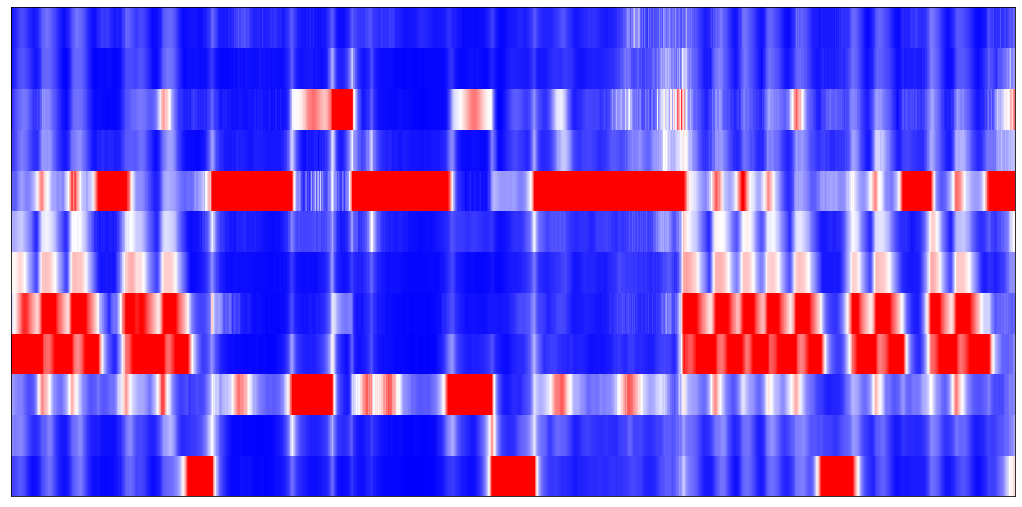

In [101]:
fig = plt.figure(figsize = (18, 9))
librosa.display.specshow(chromagram, cmap='bwr')

In [71]:
beat_chroma = librosa.util.sync(chromagram, beat_frames, aggregate=np.median)

In [72]:
beat_chroma.shape

(12, 51)

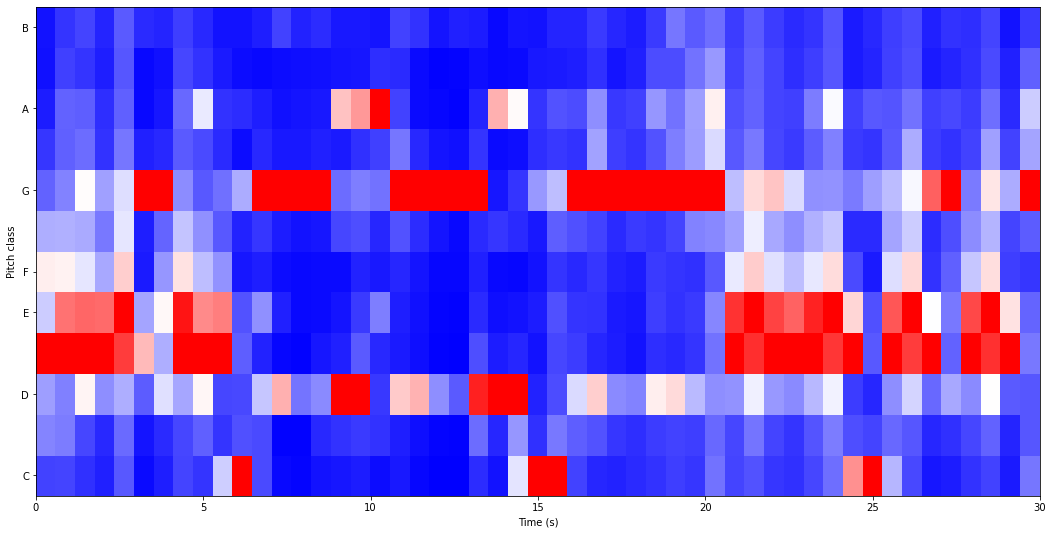

In [96]:
fig = plt.figure(figsize = (18, 9))
librosa.display.specshow(beat_chroma, cmap='bwr', sr = 870,
                         x_axis = 's', y_axis = 'chroma')

In [74]:
beat_features = np.vstack([beat_chroma, beat_mfcc_delta])

In [75]:
beat_features.shape

(52, 51)

In [76]:
pd.DataFrame(beat_features)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.140591,0.143195,0.103118,0.073659,0.182720,0.030481,0.067744,0.143341,0.112983,0.410379,...,0.718724,1.000000,0.362366,0.150746,0.052955,0.064587,0.106315,0.138361,0.061327,0.240933
1,0.268241,0.251624,0.147504,0.090298,0.214915,0.048427,0.092101,0.147165,0.197657,0.112224,...,0.161562,0.141423,0.212489,0.178161,0.085869,0.105818,0.145367,0.202202,0.081068,0.175876
2,0.315231,0.257086,0.524504,0.285720,0.348350,0.189084,0.446223,0.333543,0.520590,0.148376,...,0.128740,0.084215,0.284878,0.419671,0.210965,0.336595,0.278612,0.506896,0.185177,0.179448
3,1.000000,1.000000,1.000000,1.000000,0.881800,0.636310,0.346864,1.000000,1.000000,1.000000,...,1.000000,0.182154,1.000000,0.882403,1.000000,0.199461,1.000000,0.905861,1.000000,0.245042
4,0.404290,0.776869,0.802358,0.792786,1.000000,0.330113,0.516725,0.958284,0.729286,0.753970,...,0.583098,0.164307,0.831907,1.000000,0.501834,0.242835,0.857405,1.000000,0.561245,0.205216
5,0.538746,0.528688,0.458218,0.336409,0.601165,0.061027,0.300690,0.558972,0.379746,0.292511,...,0.155357,0.063477,0.441416,0.580075,0.109641,0.196147,0.394860,0.567653,0.130442,0.117120
6,0.349541,0.349945,0.341969,0.244826,0.454802,0.069336,0.206167,0.389500,0.288646,0.181487,...,0.091605,0.094493,0.328088,0.405336,0.095238,0.162548,0.282916,0.361043,0.141781,0.188217
7,0.200043,0.261891,0.508728,0.321712,0.442475,1.000000,1.000000,0.281811,0.181256,0.228343,...,0.246420,0.315980,0.374979,0.490328,0.813232,1.000000,0.248570,0.554804,0.345767,1.000000
8,0.117074,0.196168,0.218642,0.106623,0.237961,0.071887,0.088645,0.185300,0.152867,0.092848,...,0.125047,0.111414,0.182561,0.343713,0.125788,0.109324,0.138055,0.319564,0.138823,0.328372
9,0.065563,0.202384,0.194104,0.098748,0.198205,0.025479,0.053826,0.212908,0.463606,0.108947,...,0.135583,0.183011,0.175663,0.231772,0.133710,0.149412,0.128276,0.225066,0.091169,0.405565
